In [40]:
import os
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np
from typing import List, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
COLORS = np.array(
    [
        [0, 0, 0],  # unlabeled    =   0,
        [70, 70, 70],  # building     =   1,
        [190, 153, 153],  # fence        =   2,
        [250, 170, 160],  # other        =   3,
        [220, 20, 60],  # pedestrian   =   4,
        [153, 153, 153],  # pole         =   5,
        [157, 234, 50],  # road line    =   6,
        [128, 64, 128],  # road         =   7,
        [244, 35, 232],  # sidewalk     =   8,
        [107, 142, 35],  # vegetation   =   9,
        [0, 0, 142],  # car          =  10,
        [102, 102, 156],  # wall         =  11,
        [220, 220, 0],  # traffic sign =  12,
        [60, 250, 240],  # anomaly      =  13,
    ]
)


def color(annotated_image: np.ndarray, colors: np.ndarray = COLORS) -> Image.Image:
    print(annotated_image.shape)
    img_new = np.zeros((*annotated_image.shape, 3), dtype=np.uint8)

    for index, color in enumerate(colors):
        img_new[annotated_image == index + 1] = color

    return Image.fromarray(img_new, "RGB")

## Data Preparation


In [42]:
class StreetHazardDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, image_transform=None, target_transform=None
    ):
        # Leggi il file JSON
        with open(annotations_file, "r") as f:
            self.data = json.load(f)

        self.img_dir = img_dir  # Directory base delle immagini
        self.image_transform = image_transform
        self.target_transform = target_transform

    def __len__(self):
        # Numero di elementi nel dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Carica un campione (immagine e annotazione)
        sample = self.data[idx]
        img_path = os.path.join(self.img_dir, sample["fpath_img"])
        seg_path = os.path.join(self.img_dir, sample["fpath_segm"])

        # Carica l'immagine
        image = Image.open(img_path).convert("RGB")
        # Carica la segmentazione (opzionale)
        segmentation = Image.open(seg_path)

        # Applica trasformazioni, se specificate
        if self.image_transform:
            image = self.image_transform(image)

        if self.target_transform:
            segmentation = self.target_transform(segmentation)
            segmentation = torch.as_tensor(np.array(segmentation))

        # Restituisci immagine e annotazione
        return image, segmentation

In [1]:
# Download the following link https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
# and save it as train.tar
!wget https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar -O train.tar

--2024-12-12 22:30:15--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9386226176 (8.7G) [application/x-tar]
Saving to: ‘train.tar’

train.tar           100%[===================>]   8.74G  34.1MB/s    in 3m 30s  

2024-12-12 22:33:46 (42.5 MB/s) - ‘train.tar’ saved [9386226176/9386226176]



In [2]:
# Unzip train.tar
!tar -xf train.tar

In [3]:
# Import drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [49]:
# Percorsi dei file
# annotations_file = "./data/train/train.odgt"
# img_dir = "./data/train"
annotations_file = "/content/train/train.odgt"
img_dir = "/content/train"

# Trasformazioni
image_transform = transforms.Compose(
    [
        transforms.Resize((14 * 20, 14 * 20), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((14 * 20, 14 * 20), interpolation=InterpolationMode.NEAREST),
        # transforms.ToTensor(),
    ]
)

# Crea il dataset
dataset = StreetHazardDataset(
    annotations_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
)
dl = DataLoader(dataset, batch_size=8, shuffle=True)

## Model definition


In [44]:
class DINOv2_SemanticSegmentation(nn.Module):
    def __init__(self, num_classes: int, image_size: Tuple[int, int]):
        super().__init__()
        self.num_classes = num_classes

        self.feature_extractor = torch.hub.load(
            "facebookresearch/dinov2", "dinov2_vits14"
        )

        self.head = SegmentationHead(num_classes, d_model=384, image_size=image_size)

        self.fine_grained_features = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

    def forward(self, x):
        y = self.feature_extractor(x, is_training=True)
        backbone_features = y["x_norm_patchtokens"]

        B, HW, d_model = backbone_features.shape
        backbone_features = backbone_features.view(
            (B, int(np.sqrt(HW)), int(np.sqrt(HW)), d_model)
        )
        backbone_features = torch.permute(backbone_features, (0, 3, 1, 2))

        fine_grained_features = self.fine_grained_features(backbone_features)

        # features = torch.cat((features, fine_grained_features), dim=1)

        return self.head(backbone_features, fine_grained_features)


class SegmentationHead(nn.Module):
    def __init__(self, num_classes: int, d_model: int, image_size: Tuple[int, int]):
        super().__init__()
        self.num_classes = num_classes

        self.l1 = nn.Linear(d_model, 512)
        self.up = nn.Upsample(image_size)
        self.out = nn.Conv2d(
            512 + 512,
            num_classes,
            kernel_size=1,
            stride=1,
            padding="same",
            padding_mode="reflect",
        )

        # self.out = nn.Sequential(
        #     nn.Conv2d(512, 128, kernel_size=3, stride=1, padding="same"),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Conv2d(128, 64, kernel_size=3, stride=1, padding="same"),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding="same"),
        # )

    def forward(self, backbone_features, fine_grained_features):
        B, d_model, H, W = backbone_features.shape
        backbone_features = torch.permute(backbone_features, (0, 3, 2, 1))
        # (B, H, W, d_model)

        backbone_features = self.l1(backbone_features)
        # (B, H, W, 512)

        backbone_features = torch.permute(backbone_features, (0, 3, 2, 1))
        # (B, 512, H, W)

        backbone_features = self.up(backbone_features)
        # (B, 512, image_size, image_size)

        # Concatenate fine-grained features
        features = torch.cat((backbone_features, fine_grained_features), dim=1)
        # (B, 512 + 512, image_size, image_size)

        backbone_features = self.out(features)
        # (B, num_classes, image_size, image_size)
        return backbone_features

In [45]:
device = "cuda"
import torch, gc
import os

gc.collect()
torch.cuda.empty_cache()

In [46]:
!nvidia-smi

Thu Dec 12 22:49:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |   8753MiB / 15360MiB |     20%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [47]:
model = DINOv2_SemanticSegmentation(num_classes=13, image_size=(14 * 20, 14 * 20)).to(
    device
)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [50]:
params = model.head.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

for epoch in range(epochs):
    for images, segmentations in tqdm(dl):
        images = images.to(device)
        segmentations = segmentations.to(device)

        out = model(images)
        loss = criterion(out, segmentations.long() - 1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} - {loss.item()}")

  0%|          | 0/641 [00:00<?, ?it/s]

Epoch 0/10 - 0.5946279168128967
Epoch 0/10 - 1.0079175233840942
Epoch 0/10 - 0.7261912822723389
Epoch 0/10 - 0.6171407103538513
Epoch 0/10 - 0.8736692667007446
Epoch 0/10 - 0.7481168508529663
Epoch 0/10 - 0.6294598579406738
Epoch 0/10 - 0.5098978877067566
Epoch 0/10 - 0.6219792366027832
Epoch 0/10 - 0.5449119210243225
Epoch 0/10 - 0.5367656946182251
Epoch 0/10 - 0.5076374411582947
Epoch 0/10 - 0.4973347783088684
Epoch 0/10 - 0.6098469495773315
Epoch 0/10 - 0.6381544470787048
Epoch 0/10 - 0.5258104205131531
Epoch 0/10 - 0.48198750615119934
Epoch 0/10 - 0.47360390424728394
Epoch 0/10 - 0.9965867400169373
Epoch 0/10 - 0.54451984167099
Epoch 0/10 - 0.482848584651947
Epoch 0/10 - 0.5233535170555115
Epoch 0/10 - 0.662138044834137
Epoch 0/10 - 0.44648706912994385
Epoch 0/10 - 0.4450422525405884
Epoch 0/10 - 0.7874462604522705
Epoch 0/10 - 0.4212241470813751
Epoch 0/10 - 0.45786237716674805
Epoch 0/10 - 0.5935262441635132
Epoch 0/10 - 0.5033053159713745
Epoch 0/10 - 0.48420199751853943
Epoch 0

KeyboardInterrupt: 

torch.Size([280, 280])
torch.Size([280, 280])
tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [8, 8, 8,  ..., 7, 7, 7],
        [8, 8, 8,  ..., 7, 7, 7],
        [8, 8, 8,  ..., 7, 7, 7]])
tensor([[1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 2, 2],
        ...,
        [9, 9, 9,  ..., 8, 8, 8],
        [9, 9, 9,  ..., 8, 8, 8],
        [9, 9, 9,  ..., 8, 8, 8]], dtype=torch.uint8)


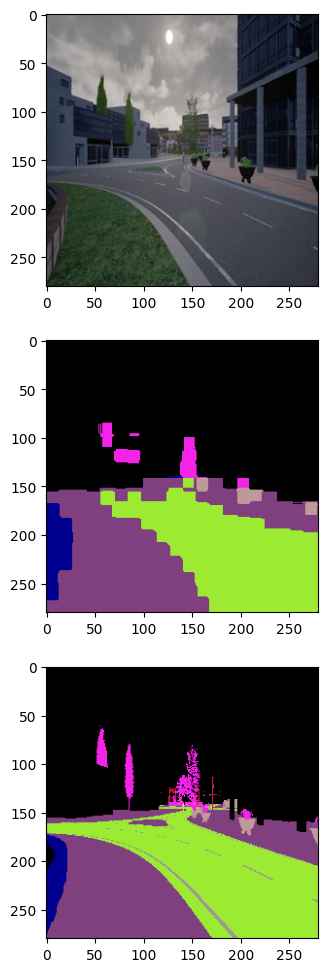

In [52]:
# Test the trained model
for images, segmentations in dl:
    images = images.to(device)
    segmentations = segmentations.to(device)

    out = model(images)
    # Plot 3 images in the same plot (RGB, predicted, ground truth)
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ax[0].imshow(images[0].permute(1, 2, 0).cpu())
    ax[1].imshow(color(out[0].argmax(dim=0).cpu()))
    ax[2].imshow(color(segmentations[0].cpu() - 1))

    print(out[0].argmax(dim=0).cpu())
    print(segmentations[0].cpu())
    break